In [35]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
from torchvision.transforms import v2
import torchvision.datasets as datasets
from torchvision import datasets, models
import yaml
import os
import pdb
import scipy
import pandas as pd
import sys
import wandb
#wandb.login()
cwd = os.getcwd()
print(cwd)
# Add the path to utils
sys.path.append('..')
from template import utils

/home/user/rogf1/CudaVisionWS23/Assignment3


In [36]:
utils.set_random_seeds()

In [37]:
torch.use_deterministic_algorithms(False)

In [71]:
config = yaml.safe_load(open("config.yaml"))
print(f"config: {config}")
batch_size = int(config["BATCH_SIZE"])

config: {'BATCH_SIZE': 64, 'NUM_EPOCHS': 10, 'LR': '3e-4', 'LRConvNext': '1e-3', 'LRSwin': '1e-4'}


In [39]:
# import zipfile as zf
# files = zf.ZipFile("data.zip", 'r')
# files.extractall('.')
# files.close()

In [40]:
data_transforms = {
    'train': transforms.Compose([
        v2.RandomResizedCrop(224),
        v2.RandomHorizontalFlip(),
        v2.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2),
        v2.ToTensor(),
        v2.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': v2.Compose([
        v2.Resize(224),
        v2.CenterCrop(224),
        v2.ToTensor(),
        v2.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}
train_dataset = datasets.ImageFolder(
root='data/car_data/car_data/test',
transform=data_transforms['train']
)
val_dataset = datasets.ImageFolder(
root='data/car_data/car_data/train',
transform=data_transforms['val'])

/home/user/rogf1/miniconda3/envs/lab2/lib/python3.10/site-packages/torchvision/transforms/v2/_deprecated.py:43: UserWarning: The transform `ToTensor()` is deprecated and will be removed in a future release. Instead, please use `v2.Compose([v2.ToImage(), v2.ToDtype(torch.float32, scale=True)])`.
  warnings.warn(


In [41]:
#create dataloaders
trainloader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)
# Create separate trainloader for the mixup training
trainloader_mixup = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)

testloader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size,
                                         shuffle=True, num_workers=2)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


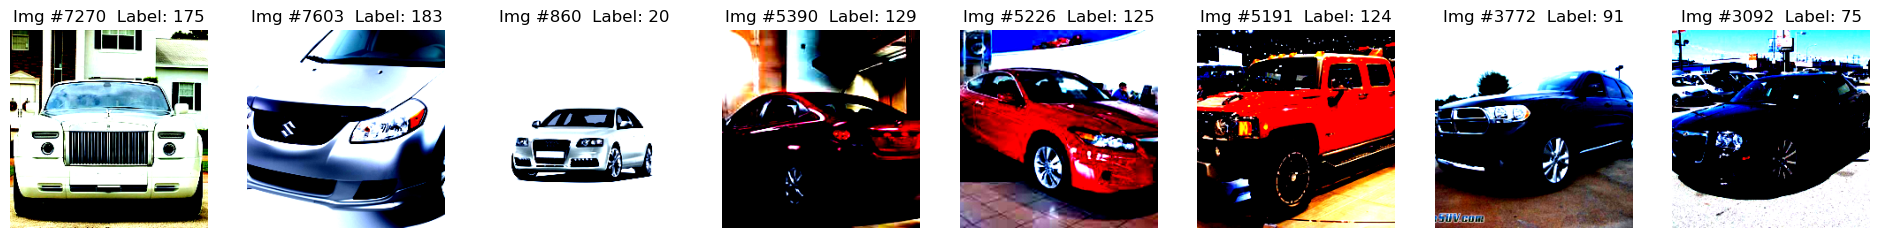

In [42]:
utils.display_images(val_dataset, NUM_images=8)

In [43]:
mixup = v2.MixUp(num_classes=196)

In [44]:
from tqdm import tqdm

In [45]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [46]:
device

device(type='cuda')

In [51]:
def train_epoch(model, train_loader, optimizer, criterion, device, mixup):

    """ 
    Training a model for one epoch.

    Parameters:
    - model (nn.Module): The neural network model to be trained.
    - train_loader (torch.utils.data.DataLoader): DataLoader for the training dataset.
    - optimizer (torch.optim.Optimizer): The optimization algorithm.
    - criterion (nn.Module): The loss function.
    - epoch (int): Current epoch number.
    - device (torch.device): The device on which to perform training (e.g., 'cuda' or 'cpu').

    Returns:
    - float: Mean training loss for the epoch.
    - list: List of individual training losses for each batch.
    """
    
    loss_list = []
    acc_list = []
    #progress_bar = tqdm(train_loader, total=len(train_loader))
    for i, (images, labels) in enumerate(train_loader):
        images, labels = mixup(images, labels)
        images = images.to(device)
        labels = labels.to(device)
        
        # Clear gradients w.r.t. parameters
        optimizer.zero_grad()
         
        # Forward pass to get output/logits
        outputs = model(images)

        # # calculate accuracy
        # with torch.no_grad():
        #     predicted = outputs.argmax(dim=-1)
        #     correct = (predicted == labels).sum().item()
        #     accuracy = correct/labels.shape[0] * 100

#         acc_list.append(accuracy)
         
        # Calculate Loss: softmax --> cross entropy loss
        loss = criterion(outputs, labels)
        loss_list.append(loss.item())
         
        # Getting gradients w.r.t. parameters
        loss.backward()
         
        # Updating parameters
        optimizer.step()
        
    mean_loss = np.mean(loss_list)
    mean_acc = []
    return mean_loss, loss_list, mean_acc

In [52]:
def train_model(model, optimizer, criterion, train_loader, valid_loader, num_epochs, scheduler=None, start_epoch=0):
    """ 
    Training a model for a given number of epochs.

    Parameters:
    - model (nn.Module): The neural network model to be trained.
    - optimizer (torch.optim.Optimizer): The optimization algorithm.
    - criterion (nn.Module): The loss function.
    - train_loader (torch.utils.data.DataLoader): DataLoader for the training dataset.
    - valid_loader (torch.utils.data.DataLoader): DataLoader for the validation dataset.
    - num_epochs (int): Number of training epochs.
    - scheduler (torch.optim.lr_scheduler._LRScheduler): Learning rate scheduler (optional).
    - start_epoch (int): Starting epoch number.

    Returns:
    - list: List of mean training losses for each epoch.
    - list: List of mean validation losses for each epoch.
    - list: List of individual training losses for each batch.
    - list: List of validation accuracies for each epoch.
    """
    wandb.watch(model, criterion, log='gradients', log_freq=100)

    train_loss = []
    val_loss =  []
    loss_iters = []
    valid_acc = []
    train_acc = []
    for epoch in tqdm(range(start_epoch, start_epoch+num_epochs)):
           
        
        # training epoch
        model.train()  # important for dropout and batch norms
        mean_loss, _, mean_acc = train_epoch(
                model=model, train_loader=train_loader, optimizer=optimizer,
                criterion=criterion, device=device, mixup = mixup
            )
        if scheduler is not None:
            scheduler.step()
        train_loss.append(mean_loss)
        train_acc.append(mean_acc)

        
        #loss_iters = loss_iters + cur_loss_iters
        
        # validation epoch
        model.eval()  # important for dropout and batch norms
        accuracy, loss = utils.eval_model(
                    model=model, eval_loader=valid_loader,
                    criterion=criterion, device=device
            )
       
        wandb.log({'epoch': epoch, 'loss': loss, 'accuracy': accuracy}, step=epoch)
        
        valid_acc.append(accuracy)
        val_loss.append(loss)
        
        if(epoch % 5 == 0 or epoch==num_epochs-1):
            print(f"Epoch {epoch+1}/{num_epochs}")
            print(f"    Train loss: {round(mean_loss, 5)}")
            print(f"    Valid loss: {round(loss, 5)}")
            print(f"    Accuracy: {accuracy}%")
            print("\n")
    
    print(f"Training completed")
    return train_loss, val_loss, loss_iters, valid_acc, train_acc

Convnext - Combined approach

In [53]:
convnext = torchvision.models.convnext_tiny(weights='DEFAULT')

In [54]:
# Freezing model parameters
for param in convnext.parameters():
    param.requires_grad = False

In [55]:
# Parameters of newly constructed modules have requires_grad=True by default
convnext.classifier[2] = nn.Linear(convnext.classifier[2].in_features, 196)
# )
# convnext.fc = nn.Sequential(
#     nn.linear(num_logits, 784),
#     nn.Linear(796, 196))
convnext = convnext.to(device)

In [56]:
model_parameters = filter(lambda p: p.requires_grad, convnext.parameters())
params = sum([np.prod(p.size()) for p in model_parameters])

In [57]:
params

150724

In [58]:
LR = float(config["LRConvNext"])

In [59]:
# classification loss function
criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer = torch.optim.AdamW(convnext.parameters(), lr=LR)

In [60]:
with wandb.init(project='finetuning_convnext_combined'):
    train_loss, val_loss, _ , valid_acc, train_acc = train_model(
            model=convnext, optimizer=optimizer, criterion=criterion,
            train_loader=trainloader, valid_loader=testloader, num_epochs=15, start_epoch=0
        )
    # Unfreezing model parameters
    for param in convnext.parameters():
        param.requires_grad = True
        
    # Lowering learning rate
    for g in optimizer.param_groups:
        g['lr'] *= 0.1
        
    next_train_loss, next_val_loss, _ , next_valid_acc, next_train_acc = train_model(
        model=convnext, optimizer=optimizer, criterion=criterion,
        train_loader=trainloader, valid_loader=testloader, num_epochs=15, start_epoch=15
    )
wandb.finish()

  7%|█████▌                                                                              | 1/15 [01:21<18:58, 81.30s/it]

Epoch 1/15
    Train loss: 5.01867
    Valid loss: 4.06855
    Accuracy: 14.329567779960708%




 40%|█████████████████████████████████▌                                                  | 6/15 [08:03<12:06, 80.69s/it]

Epoch 6/15
    Train loss: 3.89125
    Valid loss: 2.72249
    Accuracy: 39.29273084479371%




 73%|████████████████████████████████████████████████████████████▊                      | 11/15 [14:45<05:21, 80.47s/it]

Epoch 11/15
    Train loss: 3.57185
    Valid loss: 2.35501
    Accuracy: 46.57416502946955%




100%|███████████████████████████████████████████████████████████████████████████████████| 15/15 [20:08<00:00, 80.54s/it]


Epoch 15/15
    Train loss: 3.45916
    Valid loss: 2.2021
    Accuracy: 49.74214145383104%


Training completed


  7%|█████▌                                                                              | 1/15 [01:24<19:38, 84.16s/it]

Epoch 16/15
    Train loss: 3.22115
    Valid loss: 1.21334
    Accuracy: 68.23428290766208%




 40%|█████████████████████████████████▌                                                  | 6/15 [08:23<12:34, 83.80s/it]

Epoch 21/15
    Train loss: 2.36429
    Valid loss: 0.73728
    Accuracy: 82.18320235756386%




 73%|████████████████████████████████████████████████████████████▊                      | 11/15 [15:21<05:34, 83.54s/it]

Epoch 26/15
    Train loss: 2.16671
    Valid loss: 0.60654
    Accuracy: 85.80550098231828%




100%|███████████████████████████████████████████████████████████████████████████████████| 15/15 [20:52<00:00, 83.52s/it]

Training completed


accuracy,▁▂▂▃▃▃▃▄▄▄▄▄▄▄▄▆▇▇▇▇▇█████████
epoch,▁▁▁▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▇▇▇▇███
loss,█▇▆▆▆▅▅▅▅▅▅▅▄▄▄▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁
accuracy,87.5
epoch,29
loss,0.52429


In [62]:
concat_train_loss = train_loss + next_train_loss
concat_val_loss = val_loss + next_val_loss
concat_train_acc = train_acc + next_train_acc
concat_valid_acc = valid_acc + next_valid_acc

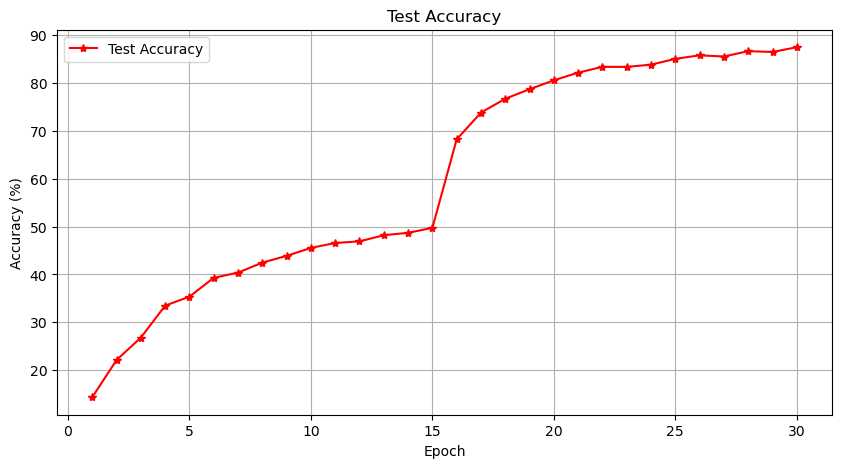

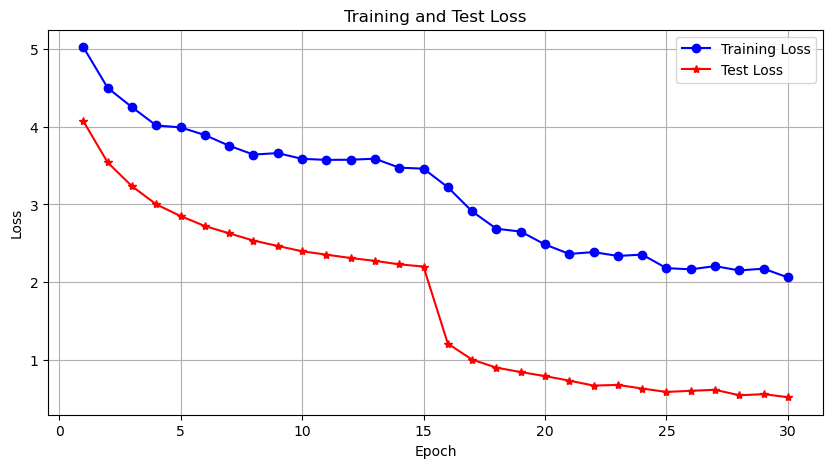

In [63]:
utils.plot_accuracy_epoch(concat_valid_acc, concat_train_acc)
utils.plot_loss_epoch(concat_train_loss, concat_val_loss)

In [65]:
swin_transformer = torchvision.models.swin_t(weights='DEFAULT')

Downloading: "https://download.pytorch.org/models/swin_t-704ceda3.pth" to /home/user/rogf1/.cache/torch/hub/checkpoints/swin_t-704ceda3.pth
100%|█████████████████████████████████████████████████████████████████████████████████| 108M/108M [00:00<00:00, 115MB/s]


In [78]:
swin_transformer.head = nn.Linear(swin_transformer.head.in_features, 196)

swin_transformer = swin_transformer.to(device)

In [79]:
model_parameters = filter(lambda p: p.requires_grad, convnext.parameters())
params = sum([np.prod(p.size()) for p in model_parameters])
print(f"Trainable parameters in Swin-Transformer model: {params}")

Trainable parameters in Swin-Transformer model: 27970852


In [80]:
LR = float(config["LRSwin"])

In [81]:
# classification loss function
criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer = torch.optim.AdamW(swin_transformer.parameters(), lr=LR)

In [82]:
with wandb.init(project='finetuning_swin_endtoend'):
    train_loss, val_loss, _ , valid_acc, train_acc = train_model(
            model=swin_transformer, optimizer=optimizer, criterion=criterion,
            train_loader=trainloader, valid_loader=testloader, num_epochs=30, start_epoch=0
        )

  3%|██▊                                                                                 | 1/30 [01:21<39:22, 81.46s/it]

Epoch 1/30
    Train loss: 5.22275
    Valid loss: 4.6121
    Accuracy: 6.139489194499018%




 20%|████████████████▊                                                                   | 6/30 [08:11<32:51, 82.15s/it]

Epoch 6/30
    Train loss: 3.0466
    Valid loss: 1.10149
    Accuracy: 73.1213163064833%




 37%|██████████████████████████████▍                                                    | 11/30 [14:58<25:47, 81.45s/it]

Epoch 11/30
    Train loss: 2.69498
    Valid loss: 0.70848
    Accuracy: 82.07269155206288%




 53%|████████████████████████████████████████████▎                                      | 16/30 [21:46<19:03, 81.64s/it]

Epoch 16/30
    Train loss: 2.49171
    Valid loss: 0.5804
    Accuracy: 84.86001964636543%




 70%|██████████████████████████████████████████████████████████                         | 21/30 [28:36<12:19, 82.16s/it]

Epoch 21/30
    Train loss: 2.1671
    Valid loss: 0.50754
    Accuracy: 86.41944990176817%




 87%|███████████████████████████████████████████████████████████████████████▉           | 26/30 [35:26<05:28, 82.17s/it]

Epoch 26/30
    Train loss: 2.10027
    Valid loss: 0.48452
    Accuracy: 86.81237721021611%




100%|███████████████████████████████████████████████████████████████████████████████████| 30/30 [40:52<00:00, 81.76s/it]

Epoch 30/30
    Train loss: 2.05143
    Valid loss: 0.46646
    Accuracy: 87.78241650294696%


Training completed


accuracy,▁▃▅▆▆▇▇▇▇▇▇███████████████████
epoch,▁▁▁▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▇▇▇▇███
loss,█▅▄▃▃▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
accuracy,87.78242
epoch,29
loss,0.46646


In [83]:
concat_train_loss = train_loss + next_train_loss
concat_val_loss = val_loss + next_val_loss
concat_train_acc = train_acc + next_train_acc
concat_valid_acc = valid_acc + next_valid_acc

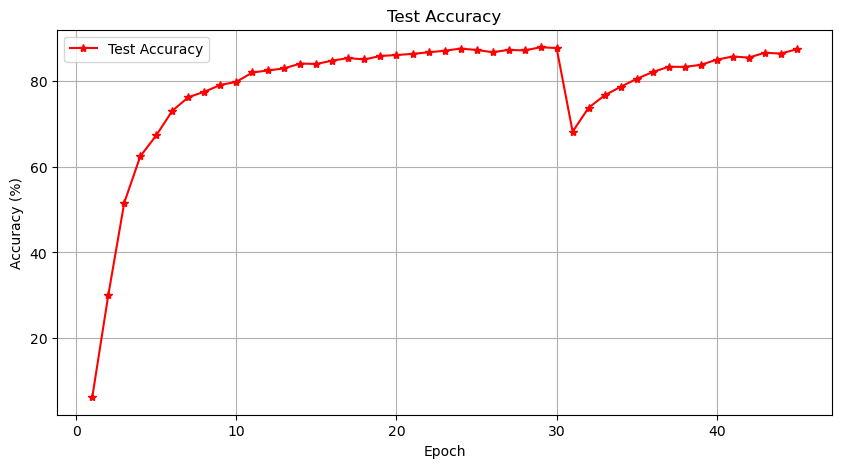

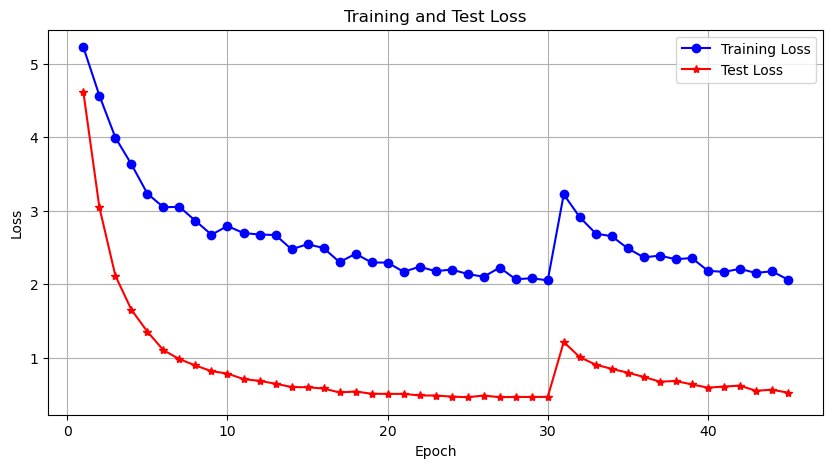

In [84]:
utils.plot_accuracy_epoch(concat_valid_acc, concat_train_acc)
utils.plot_loss_epoch(concat_train_loss, concat_val_loss)